In [1]:
#import needed packages
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.fft
import time

from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

%matplotlib inline

In [2]:
#formatting plot style
from matplotlib import rc
font = {'family': 'serif',
        'serif': ['Computer Modern'],
        'weight' : 'bold',
        'size'   : 12}

rc('font', **font)
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath}'
                          r'\boldmath')

In [3]:
#creating new colormap
top = cm.get_cmap('PuRd_r', 128)
bottom = cm.get_cmap('Blues', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='custom')

In [4]:
#v_fourier outputs the expression for the velocity field in Fourier space, 
#which is computed with a Mathematica notebook
def v_fourier(Q, qx, qy, qz, eps, F, visc_coeff):
    
    #create grid in Fourier space
    qxg, qyg, qzg = np.meshgrid(qx, qy, qz) 
    
    qsqr = qxg**2 + qyg**2 + qzg**2
    q = np.array([qxg, qyg, qzg])
    
    #will regularize integrand with Gaussian kernel to avoid Gibbs oscillations
    a = np.pi / (2*Q)
    gauss = np.exp(-a**2 * qsqr / np.pi)
    
    #all viscosity coefficients
    etaR1, etaR2, etaRo= visc_coeff[0], visc_coeff[1], visc_coeff[2]
    eta_eQ1, eta_oQ1 = visc_coeff[3], visc_coeff[4]
    eta_eQ2, eta_oQ2 = visc_coeff[5], visc_coeff[6]
    eta_eQ3, eta_oQ3 = visc_coeff[7], visc_coeff[8]
    eta_eA, eta_oA = visc_coeff[9], visc_coeff[10]
    eta_eS, eta_oS = visc_coeff[11], visc_coeff[12]
    xi = visc_coeff[13]
    eta_o1, eta_o2 = visc_coeff[14], visc_coeff[15]
    mu = visc_coeff[16]
    
    #expression for velocity field in Fourier space from Mathematica calculation
    denominator = qsqr**2 * (qzg**2 * etaRo**2 + qsqr*mu**2) + qzg**2 * qsqr**2 * etaR1**2 + 4*qzg**6 * eta_eQ2**2 \
                +4*np.sqrt(3)*qxg**2 * qzg**4 * eta_eQ2 *eta_eQ3 + 4*np.sqrt(3)*qyg**2 * qzg**4 * eta_eQ2 *eta_eQ3 \
                +3*qxg**4 * qzg**2 *eta_eQ3**2 + 6*qxg**2 *qyg**2 * qzg**2 * eta_eQ3**2 + 3*qyg**4*qzg**2 * eta_eQ3**2 \
                -4*qxg**2 * qzg**4 * eta_eQ2 * eta_o1 - 4*qyg**2 *qzg**4 *eta_eQ2 *eta_o1 \
                -2*np.sqrt(3)*qxg**4 *qzg**2 * eta_eQ3 *eta_o1 - 4*np.sqrt(3)*qxg**2 *qyg**2 *qzg**2 *eta_eQ3 *eta_o1 \
                -2*np.sqrt(3)*qyg**4 * qzg**2 *eta_eQ3*eta_o1 + qxg**4*qzg**2 *eta_o1**2 \
                +2*qxg**2 *qyg**2 *qzg**2 * eta_o1**2 + qyg**4 *qzg**2 *eta_o1**2 - 4*qxg**2 *qzg**4 *eta_eQ2*eta_o2 \
                -4*qyg**2 *qzg**4 *eta_eQ2*eta_o2 + 4*qzg**6 *eta_eQ2 *eta_o2 - 2*np.sqrt(3)*qxg**4 * qzg**2 *eta_eQ3 * eta_o2 \
                -4*np.sqrt(3)*qxg**2 *qyg**2 *qzg**2 *eta_eQ3 *eta_o2 - 2*np.sqrt(3)*qyg**4 *qzg**2 *eta_eQ3 * eta_o2 \
                +2*np.sqrt(3)*qxg**2 *qzg**4 *eta_eQ3 *eta_o2 + 2*np.sqrt(3)*qyg**2 *qzg**4 *eta_eQ3 * eta_o2\
                +2*qxg**4 *qzg**2 *eta_o1*eta_o2 + 4*qxg**2 *qyg**2 *qzg**2 *eta_o1*eta_o2 + 2*qyg**4 *qzg**2 *eta_o1 *eta_o2\
                -2*qxg**2 *qzg**4 *eta_o1*eta_o2 - 2*qyg**2 *qzg**4 *eta_o1*eta_o2 + qxg**4 *qzg**2 *eta_o2**2 \
                +2*qxg**2 *qyg**2 *qzg**2 *eta_o2**2 + qyg**4 *qzg**2 *eta_o2**2 - 2*qxg**2 *qzg**4 *eta_o2**2 \
                -2*qyg**2 *qzg**4 *eta_o2**2 + qzg**6 *eta_o2**2 + 2*qzg**2 *qsqr *etaRo*((qxg**2 + qyg**2)*(np.sqrt(3)*eta_eQ3 \
                - eta_o1 - eta_o2) + qzg**2 *(2*eta_eQ2 + eta_o2)) \
                -2*qxg**6 *mu*eta_oQ1 - 6*qxg**4 *qyg**2*mu*eta_oQ1 - 6*qxg**2 *qyg**4 *mu*eta_oQ1 \
                -2*qyg**6 *mu*eta_oQ1 + 6*qxg**2 *qzg**4*mu*eta_oQ1 + 6*qyg**2 *qzg**4*mu*eta_oQ1 + 4*qzg**6*mu*eta_oQ1 \
                -4*qxg**4 *qzg**2 *eta_oQ1**2 - 8*qxg**2 *qyg**2 *qzg**2 *eta_oQ1**2 - 4*qyg**4*qzg**2 *eta_oQ1**2 \
                +4*qzg**6 *eta_oQ1**2 - qsqr*etaR1*(qsqr*((qxg**2 + qyg**2 + 2*qzg**2)*mu - (qxg**2 + qyg**2)*etaR2) \
                + 4*qzg**4 *eta_oQ1) \
                +(qxg**2 + qyg**2)*etaR2*(-qsqr**2*mu + 2*((qxg**2 + qyg**2)**2 - qzg**4)*eta_oQ1) - 4*qxg**4 *qzg**2 *eta_oQ2**2 \
                -8*qxg**2 *qyg**2 *qzg**2 *eta_oQ2**2 - 4*qyg**4 *qzg**2 *eta_oQ2**2 + 4*np.sqrt(3)*qxg**4 *qzg**2 *eta_oQ2*eta_oQ3 \
                +8*np.sqrt(3)*qxg**2 *qyg**2*qzg**2 *eta_oQ2 *eta_oQ3 + 4*np.sqrt(3)*qyg**4 *qzg**2 *eta_oQ2 *eta_oQ3 \
                -3*qxg**4 *qzg**2 *eta_oQ3**2 - 6*qxg**2 *qyg**2 *qzg**2 *eta_oQ3**2 - 3*qyg**4*qzg**2 *eta_oQ3**2 \
                +eps**2 #add epsilon^2 to regularize integrand
    
    vfx = F[2]*gauss/denominator *\
        qzg*(qsqr*(qyg*etaRo+ qxg*mu) - qxg*qzg**2 *etaR1 - qxg*(qxg**2 + qyg**2)*etaR2 + 2*qyg* qzg**2*eta_eQ2 \
             +np.sqrt(3)*qxg**2*qyg*eta_eQ3 + np.sqrt(3)*qyg**3 *eta_eQ3 - qxg**2*qyg*eta_o1 - qyg**3*eta_o1\
             -qxg**2*qyg*eta_o2 -qyg**3*eta_o2 + qyg*qzg**2*eta_o2 + 2*qxg*qzg**2*eta_oQ1 - 2*qxg**2 *qyg*eta_oQ2 - 2*qyg**3 *eta_oQ2 \
             +np.sqrt(3)*qxg**2 *qyg*eta_oQ3 + np.sqrt(3)*qyg**3*eta_oQ3)
    
    vfy = -F[2]*gauss/denominator * \
        qzg*(qsqr * (qxg*etaRo- qyg*mu) + qyg *qzg**2*etaR1 + qyg*(qxg**2 + qyg**2)*etaR2 + 2*qxg*qzg**2*eta_eQ2 \
            +np.sqrt(3)*qxg**3*eta_eQ3 + np.sqrt(3)*qxg*qyg**2*eta_eQ3 - qxg**3*eta_o1 -qxg*qyg**2*eta_o1 \
            -qxg**3*eta_o2 - qxg*qyg**2*eta_o2 + qxg*qzg**2*eta_o2 - 2*qyg*qzg**2 *eta_oQ1 - 2*qxg**3 *eta_oQ2 \
            -2*qxg*qyg**2 * eta_oQ2 + np.sqrt(3)*qxg**3*eta_oQ3 + np.sqrt(3)*qxg*qyg**2*eta_oQ3)
    
    vfz = -F[2]*gauss/denominator * (qxg**2 + qyg**2)*(qsqr*mu - (qxg**2 + qyg**2)*etaR2 - qzg**2*(etaR1 - 2*eta_oQ1))
    
    return [vfx, vfy, vfz]

In [5]:
#v_fourier_ifft performs the numerical inversion to compute the real space velocity field
def v_fourier_ifft(Q, dq, eps, visc_coeff, F):
    
    #set up grid in Fourier space, ranging from -Q to Q with spacing dq
    xs = scipy.fft.fftfreq(len(np.arange(-Q, Q+dq, dq)), dq/(2*np.pi))
    qs = scipy.fft.ifftshift(np.linspace(-Q, Q, len(xs)))
    
    #compute Fourier space velocity field on this grid using analytical expression
    vf = v_fourier(Q, qs, qs, qs, eps, F, visc_coeff)
    
    #invert
    v = []
    for i in range(3):
        vi = 1 / (2*np.pi)**3 * (2*Q)**3 * scipy.fft.irfftn(vf[i], s = [len(xs), len(xs), len(xs)], workers = 3)
        
        v.append(scipy.fft.fftshift(vi))
    
    return scipy.fft.fftshift(xs), v

## example: comparison with standard Stokeslet

In [30]:
eps = 0.00001 #add epsilon^2 to denominator of integrand to regularize at q = 0
dq = 0.07 #spacing in Fourier space
Q = 10 #max value of q

F = np.array([0, 0, 1]) #external force

#values of viscosity coefficients
etaR1, etaR2, etaRo = 0, 0, 0
eta_eQ1, eta_oQ1 = 0, 0
eta_eQ2, eta_oQ2 = 0, 0
eta_eQ3, eta_oQ3 = 0, 0
eta_eA, eta_oA = 0, 0
eta_eS, eta_oS = 0, 0
xi = 0
eta_o1, eta_o2 = 0, 0
mu = 1

visc_coeff_list = [etaR1, etaR2, etaRo, eta_eQ1, eta_oQ1, eta_eQ2, eta_oQ2, eta_eQ3, eta_oQ3, eta_eA,
                  eta_oA, eta_eS, eta_oS, xi, eta_o1, eta_o2, mu]

#call inverse FFT function
fft_xs, v = v_fourier_ifft(Q, dq, eps, visc_coeff_list, F)

#compute velocities in cylindrical coordinates from v (Cartesian coordinates)
x, y, z = np.meshgrid(fft_xs, fft_xs, fft_xs)
vr = (v[0]*x + v[1]*y) / np.sqrt(x**2+ y**2)
vphi = (-v[0]*y + v[1]*x) / np.sqrt(x**2 + y**2)

/Users/talikhain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/talikhain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


In [31]:
#analytical expression for Stokeslet with shear viscosity mu and force in -z
Fz = -F[2]

x, y, z = np.meshgrid(fft_xs, fft_xs, fft_xs)

vx_theory = Fz/(8*np.pi*mu) * z*x / (x**2 + y**2 + z**2)**(3/2)
vy_theory = Fz/(8*np.pi*mu) * z*y / (x**2 + y**2 + z**2)**(3/2)
vz_theory = Fz/(8*np.pi*mu) * (x**2 + y**2 + 2*z**2) / (x**2 + y**2 + z**2)**(3/2)

vr_theory = (vx_theory*x + vy_theory*y) / np.sqrt(x**2+ y**2)
vphi_theory = (-vx_theory*y + vy_theory*x) / np.sqrt(x**2 + y**2)

/Users/talikhain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/Users/talikhain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/Users/talikhain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/Users/talikhain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/talikhain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


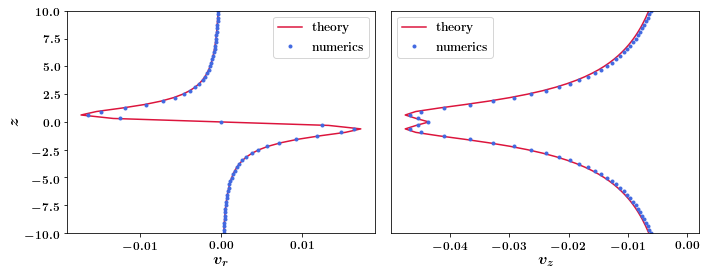

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ind1 = 145
ind2 = 145

plt.subplot(121)
plt.plot(vr_theory[ind1, ind2, :] - np.nanmean(vr_theory), fft_xs, color='crimson', label=r'\textbf{theory}')
plt.plot(vr[ind1, ind2, :] - np.nanmean(vr), fft_xs, marker='.', linestyle='None', color='royalblue', label=r'\textbf{numerics}')
plt.ylim(-10, 10)
plt.ylabel(r'\textbf{$z$}',fontsize=16)
plt.xlabel(r'\textbf{$v_r$}',fontsize=16)
plt.xticks([-0.01, 0, 0.01])
plt.legend()

plt.subplot(122)
plt.plot(vz_theory[ind1, ind2, :] - np.nanmean(vz_theory), fft_xs, color='crimson', label=r'\textbf{theory}')
plt.plot(v[2][ind1, ind2, :] - np.nanmean(v[2]), fft_xs, marker='.', linestyle='None', color='royalblue', label=r'\textbf{numerics}')
plt.ylim(-10, 10)
#plt.ylabel(r'\textbf{$z$}',fontsize=16)
plt.yticks([])
plt.xlabel(r'\textbf{$v_z$}',fontsize=16)
plt.legend()

plt.tight_layout()
plt.savefig('/Users/talikhain/Documents/UChicago/Soft Matter/Vitelli/Odd viscosity in three dimensional flows/Figures2/num_validation.png', dpi=300)
plt.show()

## example: Stokeslet with perturbative odd shear viscosities, $\eta_1^o = -2\eta_2^o$

In [6]:
eps = 0.00001 #add epsilon^2 to denominator of integrand to regularize at q = 0
dq = 0.07 #spacing in Fourier space
Q = 10 #max value of q

F = np.array([0, 0, 1]) #external force

#values of viscosity coefficients
etaR1, etaR2, etaRo = 0, 0, 0
eta_eQ1, eta_oQ1 = 0, 0
eta_eQ2, eta_oQ2 = 0, 0
eta_eQ3, eta_oQ3 = 0, 0
eta_eA, eta_oA = 0, 0
eta_eS, eta_oS = 0, 0
xi = 0
eta_o1, eta_o2 = -0.2, 0.1
mu = 1

visc_coeff_list = [etaR1, etaR2, etaRo, eta_eQ1, eta_oQ1, eta_eQ2, eta_oQ2, eta_eQ3, eta_oQ3, eta_eA,
                  eta_oA, eta_eS, eta_oS, xi, eta_o1, eta_o2, mu]

fft_xs, v = v_fourier_ifft(Q, dq, eps, visc_coeff_list, F)

x, y, z = np.meshgrid(fft_xs, fft_xs, fft_xs)

vr = (v[0]*x + v[1]*y) / np.sqrt(x**2+ y**2)
vphi = (-v[0]*y + v[1]*x) / np.sqrt(x**2 + y**2)

/Users/talikhain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/Users/talikhain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


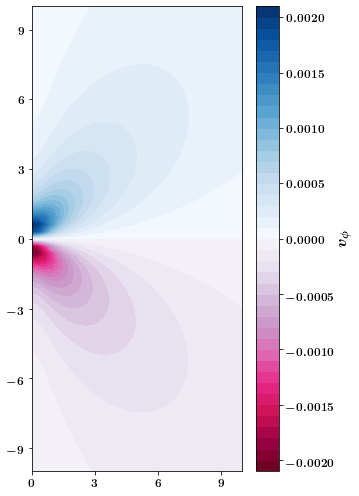

In [117]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 7))

plt.subplot(111)

ind = 145
cont = plt.contourf(fft_xs, fft_xs, np.transpose(vphi[ind,:,:]), 50, cmap=newcmp)#, vmin = -1, vmax = 1)
circle = mpatches.Circle([0, 0], radius = 1, color = 'white')
axes.add_patch(circle)

plt.xlim(0, 10)
plt.ylim(-10, 10)
plt.xticks([0, 3, 6, 9], size=12)
plt.yticks([-9, -6, -3, 0, 3, 6, 9], size=12)
#plt.text(0.5, 8.5, coeff_label_list[count], fontsize=16)

cb = plt.colorbar(cont)#, ticks = np.arange(-2, 2.5, 0.5))
cb.set_label(label=r'\textbf{$v_{\phi}$}', size=16)
cb.ax.tick_params(labelsize=12) 

plt.tight_layout()
plt.show()

## example: theory and numerics comparison for Stokeslet with odd viscosity

In [13]:
eps = 0.00001 #add epsilon^2 to denominator of integrand to regularize at q = 0
dq = 0.07 #spacing in Fourier space
Q = 10 #max value of q

F = np.array([0, 0, 1]) #external force

#values of viscosity coefficients
etaR1, etaR2, etaRo = 0, 0, 0
eta_eQ1, eta_oQ1 = 0, 0
eta_eQ2, eta_oQ2 = 0, 0
eta_eQ3, eta_oQ3 = 0, 0
eta_eA, eta_oA = 0, 0
eta_eS, eta_oS = 0, 0
xi = 0
eta_o1, eta_o2 = 0, 0
mu = 1

vphi_list = []

for i in range(3):
    eta_o_list = [0, 0, 0]
    eta_o_list[i] = 0.01
    eta_o1, eta_o2, etaRo = eta_o_list[0], eta_o_list[1], eta_o_list[2]

    visc_coeff_list = [etaR1, etaR2, etaRo, eta_eQ1, eta_oQ1, eta_eQ2, eta_oQ2, eta_eQ3, eta_oQ3, eta_eA,
                      eta_oA, eta_eS, eta_oS, xi, eta_o1, eta_o2, mu]

    fft_xs, v = v_fourier_ifft(Q, dq, eps, visc_coeff_list, F)

    x, y, z = np.meshgrid(fft_xs, fft_xs, fft_xs)
    vphi = (-v[0]*y + v[1]*x) / np.sqrt(x**2 + y**2)
    
    vphi_list.append(vphi)

/Users/talikhain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


In [15]:
#analytical expression for Stokeslet with shear viscosity mu, force in -z,
#and perturbative odd viscosity for eta_1^o, eta_2^o, eta_R^o
Fz = -F[2]
eps = 0.01
x, y, z = np.meshgrid(fft_xs, fft_xs, fft_xs)

vphi_theory_eta1 = eps*Fz/(32*mu*np.pi) * np.sqrt(x**2 + y**2)*z * (x**2 + y**2 + 4*z**2) / (x**2 + y**2 + z**2)**(5/2)
vphi_theory_eta2 = -eps*Fz/(16*mu*np.pi) * np.sqrt(x**2 + y**2)*z * (x**2 + y**2 - 2*z**2) / (x**2 + y**2 + z**2)**(5/2)
vphi_theory_etaR = -eps*Fz/(8*mu*np.pi) * np.sqrt(x**2 + y**2)*z / (x**2 + y**2 + z**2)**(3/2)

vphi_theory_list = [vphi_theory_eta1, vphi_theory_eta2, vphi_theory_etaR]

/Users/talikhain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/Users/talikhain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/Users/talikhain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


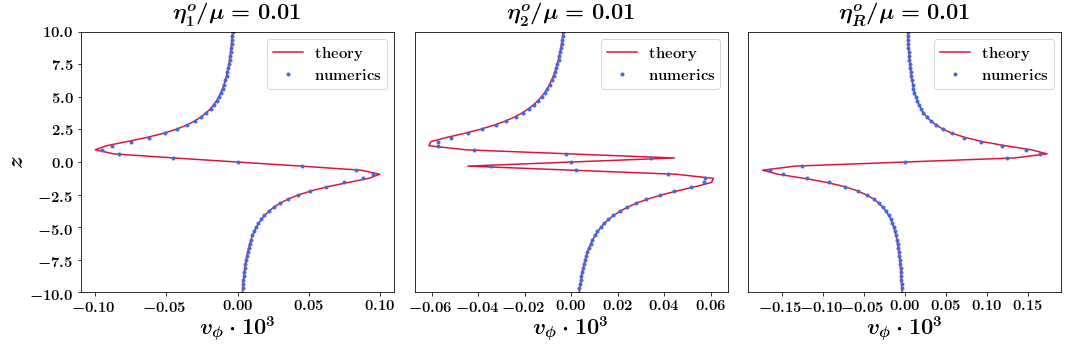

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

ind1 = 145
ind2 = 145

title_list = [r'\textbf{$\eta_1^o/\mu = 0.01$}', r'\textbf{$\eta_2^o/\mu = 0.01$}', r'\textbf{$\eta_R^o/\mu = 0.01$}']
for i in range(3):
    
    plt.subplot(1, 3, i+1)
    plt.plot((vphi_theory_list[i][ind1, ind2, :] - np.nanmean(vphi_theory_list[i]))*1e3, fft_xs, color='crimson', label=r'\textbf{theory}')
    plt.plot((vphi_list[i][ind1, ind2, :] - np.nanmean(vphi_list[i]))*1e3, fft_xs, marker='.', linestyle='None', color='royalblue', label=r'\textbf{numerics}')
    plt.ylim(-10, 10)
    if i == 0:
        plt.ylabel(r'\textbf{$z$}',fontsize=22)
    plt.xlabel(r'\textbf{$v_{\phi} \cdot 10^3$}',fontsize=22)
    plt.title(title_list[i], fontsize=22)
    plt.xticks(size=15)
    plt.yticks(size=15)
    if i > 0:
        plt.yticks([])
    
    plt.legend(fontsize=15)

plt.tight_layout()
plt.savefig('/Users/talikhain/Documents/UChicago/Soft Matter/Vitelli/Odd viscosity in three dimensional flows/Figures2/num_validation_odd.png', dpi=300)
plt.show()